In [1]:
for (pkg in c("ggplot2", "dplyr", "patchwork")) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                pkg,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}

In [2]:
color_pallete_for_dose <- c(
    "0.0" = "#85FF33",
    "0.61" = "#75FF1A",
    "1.22" = "#62FF00",
    "2.44" = "#4DC507",
    "4.88" = "#398E0B",
    "9.77" = "#265A0C",
    "19.53" = "#132B08",
    "39.06" = "#620B8E",
    "78.13" = "#410C5A",
    "156.25" = "#21082B"
)
font_size <- 24
plot_themes <- (
    theme_bw()
    + theme(
        legend.position = "bottom",
        legend.text = element_text(size = font_size),
        legend.title = element_text(size = font_size),
        axis.title.x = element_text(size = font_size),
        axis.text.x = element_text(size = font_size),
        axis.title.y = element_text(size = font_size),
        axis.text.y = element_text(size = font_size),
        strip.text = element_text(size = font_size -2),
    )
    
    
)

In [3]:
actual_results_file_path <- file.path("../../data/CP_aggregated/endpoints/aggregated_whole_image.parquet")
actual_results <- arrow::read_parquet(actual_results_file_path)
actual_results$Metadata_Time <- 13
actual_results$shuffled <- "FALSE"

# prepend Terminal to each non metadata column name
actual_results <- actual_results %>%
  rename_with(~ paste0("Terminal_", .), -c(Metadata_Time, Metadata_dose, Metadata_Well, shuffled))

columns_to_keep <- colnames(actual_results)



results_file_path <- file.path("../results/predicted_terminal_profiles_from_all_time_points.parquet")
results <- arrow::read_parquet(results_file_path)

subset_results <- results[, colnames(results) %in% columns_to_keep]


In [4]:
head(actual_results)

Metadata_Well,Metadata_dose,Terminal_Intensity_LowerQuartileIntensity_AnnexinV,Terminal_Intensity_MADIntensity_AnnexinV,Terminal_Intensity_MADIntensity_DNA,Terminal_Intensity_MaxIntensity_AnnexinV,Terminal_Intensity_MaxIntensity_DNA,Terminal_Intensity_TotalIntensity_AnnexinV,Terminal_Intensity_UpperQuartileIntensity_AnnexinV,Terminal_Intensity_UpperQuartileIntensity_DNA,⋯,Terminal_Texture_DifferenceVariance_DNA_3_00_256,Terminal_Texture_InfoMeas1_AnnexinV_3_03_256,Terminal_Texture_InfoMeas1_DNA_3_01_256,Terminal_Texture_InfoMeas2_AnnexinV_3_03_256,Terminal_Texture_InfoMeas2_DNA_3_00_256,Terminal_Texture_InverseDifferenceMoment_AnnexinV_3_00_256,Terminal_Texture_SumVariance_AnnexinV_3_03_256,Terminal_Texture_SumVariance_DNA_3_02_256,Metadata_Time,shuffled
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
C-02,0.00,-0.5452753,-0.4805893,0,1.2464183,0.2662475,-0.9213347,-1.003397,0.0000000,⋯,-0.2882715,0.77682707,0.93861695,-1.20853623,0.2929019,1.1624581,-0.1916276,0.11774522,13,FALSE
C-03,0.61,-0.5452753,-0.1517650,0,-0.4533937,1.0256937,-1.0443208,-1.230912,0.9013878,⋯,-0.7011644,0.01274285,0.76918960,-0.25276588,0.1863562,1.0412479,-1.1725048,0.07689638,13,FALSE
C-04,1.22,-0.5452753,-0.8916197,0,-0.6727368,1.1540890,-1.7881348,-1.230912,1.8027756,⋯,-1.0076323,-0.74208856,0.98568499,-0.03811802,0.4948702,1.9091393,-1.2965421,1.16957868,13,FALSE
C-05,2.44,-0.5452753,-1.1382379,0,-0.7129174,0.4847928,-1.7841645,-1.685941,0.0000000,⋯,-0.4211875,0.26597145,-0.40978988,-0.76314291,-0.8009966,1.2522524,-1.0873288,-0.20497421,13,FALSE
C-06,4.88,-0.5452753,-0.6450015,0,-0.7393162,0.7579751,-0.7776878,-1.079236,0.0000000,⋯,-0.7232329,-0.32843261,-0.02731316,0.01162253,-0.2512367,0.5312674,-0.8223219,0.40567124,13,FALSE
C-07,9.77,0.4971627,-0.8916197,0,-0.8819863,-0.1039142,-0.9537968,-1.989294,0.0000000,⋯,-0.3288761,-0.47685977,-0.22947842,-0.34500086,0.7541508,1.1174887,-0.8727146,0.89818728,13,FALSE


In [5]:
dim(actual_results)
dim(subset_results)

[1] 30 27

[1] 780  27

In [6]:

# merge the two dataframes on the columns "Metadata_Time" and "Metadata_dose" Metadata_Well
merged_results <- rbind(actual_results, subset_results)
merged_results$Metadata_Time <- as.numeric(merged_results$Metadata_Time) * 30
merged_results$shuffled <- gsub("TRUE", "Shuffled", merged_results$shuffled)
merged_results$shuffled <- gsub("FALSE", "Not shuffled", merged_results$shuffled)
merged_results$Metadata_dose <- as.numeric(merged_results$Metadata_dose)
merged_results$Metadata_dose <- factor(
    merged_results$Metadata_dose, 
    levels = c(
        '0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)


In [7]:

# map the train_test to the merged data
train_test_df <- results %>%
  select(Metadata_Well, Metadata_data_split) %>%
  distinct() %>%
  mutate(Metadata_data_split = gsub("train", "Train", Metadata_data_split)) %>%
  mutate(Metadata_data_split = gsub("test", "Test", Metadata_data_split)) %>%
  mutate(Metadata_data_split = gsub("validation", "Validation", Metadata_data_split))
# map the data split by well to the merged data
merged_results <- merged_results %>%
  left_join(train_test_df, by = c("Metadata_Well")) 
merged_results$Metadata_data_split <- gsub("non_Trained_pair", "Train", merged_results$Metadata_data_split)


In [8]:
# get the pca of the results
metadata_columns <- c("Metadata_Time", "Metadata_dose", "Metadata_Well", "shuffled", "Metadata_data_split")
# drop the metadata columns from the dataframe
pcadf <- merged_results[, !colnames(merged_results) %in% metadata_columns]

pca <- prcomp(pcadf, center = TRUE, scale. = TRUE)
# get the pca of the results
pca_df <- data.frame(pca$x)
pca_df$Metadata_Time <- merged_results$Metadata_Time
pca_df$Metadata_dose <- merged_results$Metadata_dose
pca_df$Metadata_Well <- merged_results$Metadata_Well
pca_df$Metadata_data_split <- merged_results$Metadata_data_split
pca_df$shuffled <- merged_results$shuffled
pca_df$Metadata_Time <- as.double((pca_df$Metadata_Time))
pca_df$Metadata_dose <- as.factor(pca_df$Metadata_dose)

pca_df$PC1 <- as.numeric(pca_df$PC1)
pca_df <- pca_df %>%
  mutate(Group = Metadata_Well) %>%
  arrange(Metadata_Well, Metadata_Time)
pca_df <- pca_df %>% arrange(Group)
head(pca_df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC20,PC21,PC22,PC23,Metadata_Time,Metadata_dose,Metadata_Well,Metadata_data_split,shuffled,Group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
1,0.08309326,1.8859015,-2.0145280,-1.80876168,0.47717239,0.11299224,-0.14121881,0.2373266,-0.4912311,1.20934789,⋯,-1.019291666,-0.09893217,0.69844714,-0.01159395,0,0,C-02,Test,Not shuffled,C-02
2,-0.89967716,-0.8008143,-0.3794006,-0.03012434,0.13223167,-0.03217682,-0.01980333,0.1064811,-0.2286223,-0.14328979,⋯,-0.001253303,0.15356512,0.07706526,-0.20773393,0,0,C-02,Test,Shuffled,C-02
3,2.90053796,3.1821788,-1.2017814,0.23718699,-0.72849730,-0.68437332,-1.09008233,0.6826284,-0.3381156,-1.17133822,⋯,0.030360122,0.09206971,0.43382222,0.01250614,30,0,C-02,Test,Not shuffled,C-02
4,-0.85596187,-0.5617763,-0.5662347,-0.32981500,-0.54553685,-0.19670678,0.24755414,-0.1897061,-0.3261498,0.04609767,⋯,0.038569602,0.59492501,-0.09680529,0.18919124,30,0,C-02,Test,Shuffled,C-02
5,1.38788953,3.1238280,-1.3142934,-0.75375414,0.12688943,-0.35721505,-1.27747249,0.6743238,-0.2701125,-0.04665828,⋯,-0.342033363,-0.12580106,0.03243729,0.30451011,60,0,C-02,Test,Not shuffled,C-02
6,-0.82430597,-0.8816558,-0.6596136,-0.12786205,0.03293253,-0.06265152,-0.01100169,-0.1329533,-0.1995435,-0.01680048,⋯,0.097669732,0.05233948,-0.18022356,-0.01130431,60,0,C-02,Test,Shuffled,C-02


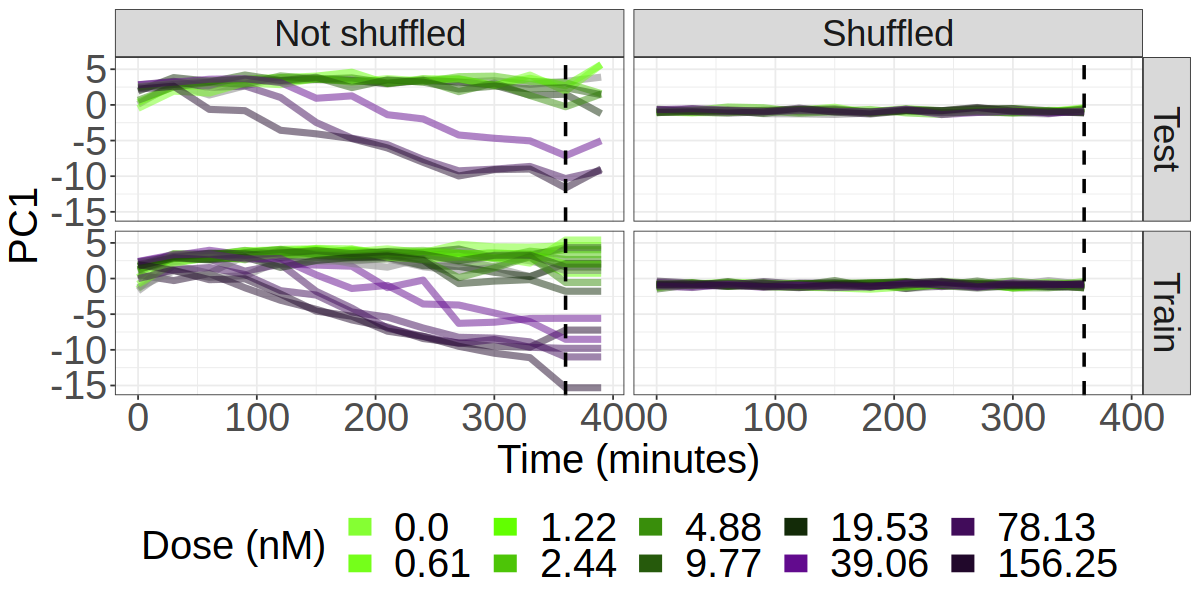

In [9]:
width <- 10
height <- 5
options(repr.plot.width=width, repr.plot.height=height)
# plot the pca
pca1_plot <- (
    ggplot(pca_df, aes(x = Metadata_Time, y = PC1, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_grid(Metadata_data_split ~ shuffled)
    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)
    + labs(x="Time (minutes)", y="PC1", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_pallete_for_dose)
    + guides(color = guide_legend( override.aes = list(size = 5, alpha = 1)))
)
ggsave(
    filename = "../figures/predicted_PC1.png",
    plot = pca1_plot,
    width = width,
    height = height,
    dpi = 600
)
pca1_plot

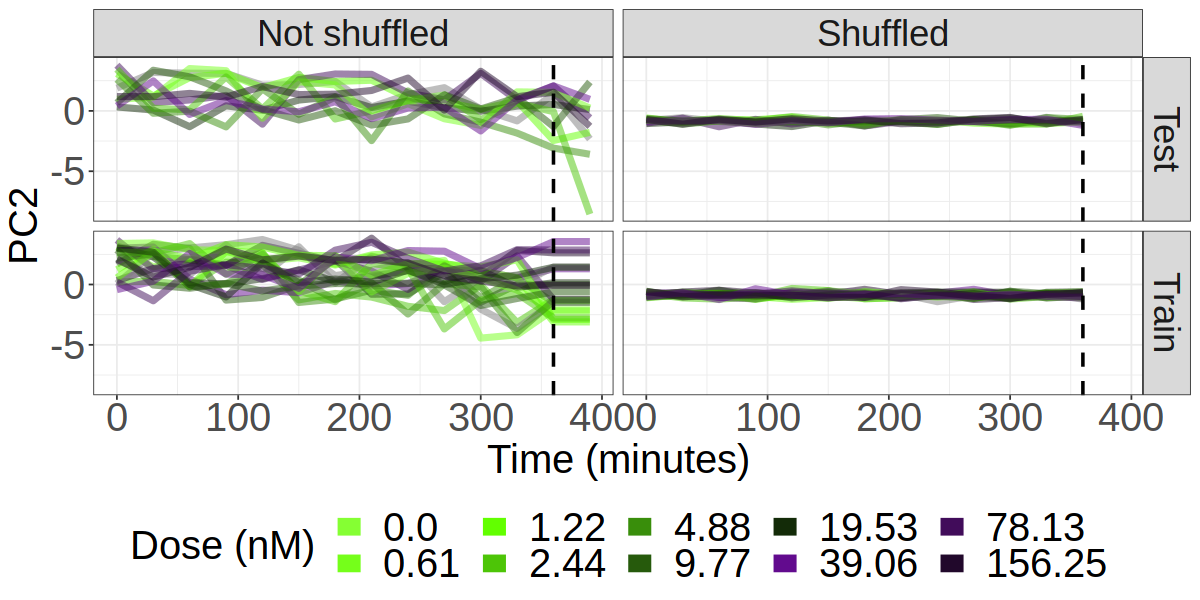

In [10]:
width <- 10
height <- 5
options(repr.plot.width=width, repr.plot.height=height)
# plot the pca
pca2_plot <- (
    ggplot(pca_df, aes(x = Metadata_Time, y = PC2, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_grid(Metadata_data_split ~ shuffled)
    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)
    + labs(x="Time (minutes)", y="PC2", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_pallete_for_dose)
    + guides(color = guide_legend( override.aes = list(size = 5, alpha = 1)))
)
ggsave(
    filename = "../figures/predicted_PC2.png",
    plot = pca2_plot,
    width = width,
    height = height,
    dpi = 600
)
pca2_plot

In [11]:
pca_df$Metadata_shuffle_plus_data_split <- paste0(pca_df$shuffled, "\n", pca_df$Metadata_data_split)
pca_df$Metadata_Time <- paste0(pca_df$Metadata_Time, " min.")

pca_df$Metadata_Time <- factor(
    pca_df$Metadata_Time, 
    levels = c(
        '0 min.',
        '30 min.',
        '60 min.',
        '90 min.',
        '120 min.',
        '150 min.',
        '180 min.',
        '210 min.',
        '240 min.',
        '270 min.',
        '300 min.',
        '330 min.',
        '360 min.',
        '390 min.'
    )
)
unique(pca_df$Metadata_Time)

[1] 0 min.   30 min.  60 min.  90 min.  120 min. 150 min. 180 min. 210 min.
 [9] 240 min. 270 min. 300 min. 330 min. 360 min. 390 min.
14 Levels: 0 min. 30 min. 60 min. 90 min. 120 min. 150 min. ... 390 min.

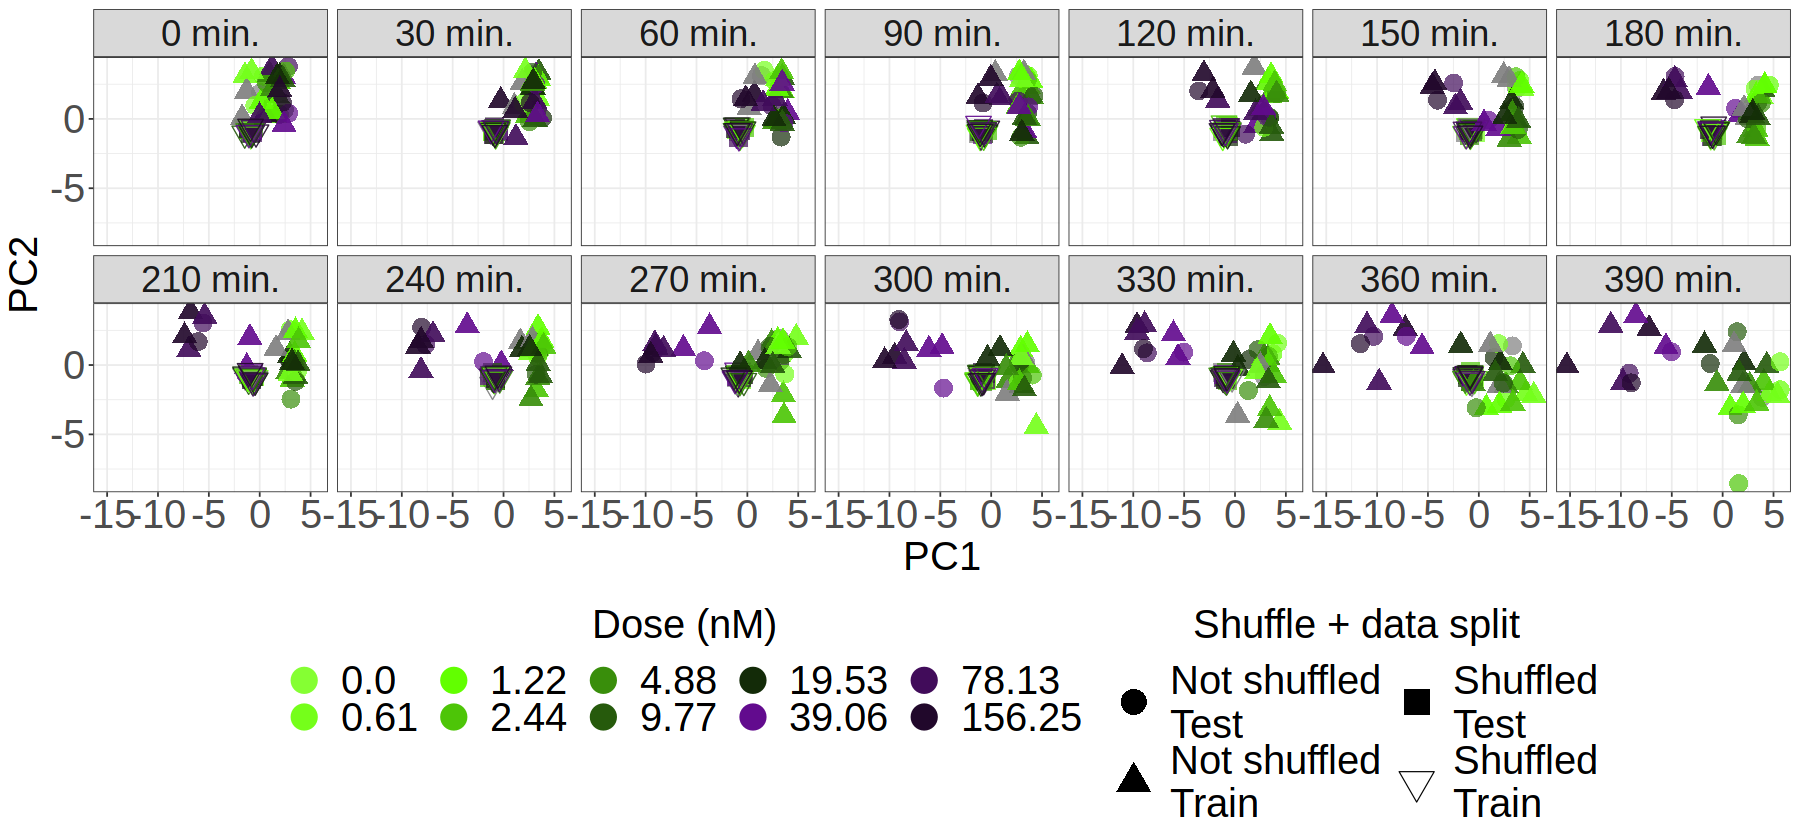

In [12]:
# plot PCA1 vs PCA2 over time
width <- 15
height <- 7
options(repr.plot.width=width, repr.plot.height=height)
pca_over_time_plot <- (
    ggplot(pca_df, aes(x = PC1, y = PC2, color = Metadata_dose))
    + geom_point(aes(shape = Metadata_shuffle_plus_data_split), size = 5, alpha = 0.7)
    + theme_minimal() 
    + facet_wrap( ~ Metadata_Time, ncol = 7)
    + labs(x="PC1", y="PC2", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_pallete_for_dose)
    + scale_shape_manual(values = c(16, 17,15,6), name = "Shuffle + data split")
    
    + guides(
        color = guide_legend(
            override.aes = list(size = 7, alpha = 1),
            title.position = "top",
            title.hjust = 0.5,
            ),
        shape = guide_legend(
            override.aes = list(size = 7, alpha = 1),
            title.position = "top",
            title.hjust = 0.5,
            nrow = 2,
        )
    )

)
ggsave(
    filename = "../figures/pca_over_time.png",
    plot = pca_over_time_plot,
    width = width,
    height = height,
    dpi = 600
)
pca_over_time_plot

In [13]:

# merged_results$Metadata_dose <- gsub('0', '0.0', merged_results$Metadata_dose)
unique(merged_results$Metadata_dose)
merged_results <- merged_results %>%
  mutate(Group = Metadata_Well) %>%
  arrange(Metadata_Well, Metadata_Time)
merged_results <- merged_results %>% arrange(Group)
head(merged_results)

[1] 0      0.61   1.22   2.44   4.88   9.77   19.53  39.06  78.13  156.25
Levels: 0 0.61 1.22 2.44 4.88 9.77 19.53 39.06 78.13 156.25

Metadata_Well,Metadata_dose,Terminal_Intensity_LowerQuartileIntensity_AnnexinV,Terminal_Intensity_MADIntensity_AnnexinV,Terminal_Intensity_MADIntensity_DNA,Terminal_Intensity_MaxIntensity_AnnexinV,Terminal_Intensity_MaxIntensity_DNA,Terminal_Intensity_TotalIntensity_AnnexinV,Terminal_Intensity_UpperQuartileIntensity_AnnexinV,Terminal_Intensity_UpperQuartileIntensity_DNA,⋯,Terminal_Texture_InfoMeas1_DNA_3_01_256,Terminal_Texture_InfoMeas2_AnnexinV_3_03_256,Terminal_Texture_InfoMeas2_DNA_3_00_256,Terminal_Texture_InverseDifferenceMoment_AnnexinV_3_00_256,Terminal_Texture_SumVariance_AnnexinV_3_03_256,Terminal_Texture_SumVariance_DNA_3_02_256,Metadata_Time,shuffled,Metadata_data_split,Group
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
C-02,0,0.93081693,-0.4707246,0,-0.3641735,-0.5638983,-1.3173535,-0.6378574,-0.9644850,⋯,-0.9598636,0.4375517,2.4576490,-0.7486068,-0.006132765,1.2389215,0,Not shuffled,Test,C-02
C-02,0,0.12188506,-1.5714638,0,-0.4102336,0.2406093,0.2716688,-0.3625648,-0.4236523,⋯,-3.2723714,0.6835118,0.6839952,-0.1749294,0.583908067,1.8317481,0,Shuffled,Test,C-02
C-02,0,-0.10953618,0.2979021,0,-0.6856043,-0.5524110,-1.1761721,-0.7129372,-0.2974580,⋯,-0.2504492,0.2866041,2.3121832,1.4210777,0.020616768,-0.4218541,30,Not shuffled,Test,C-02
C-02,0,0.13856406,-1.1201525,0,-0.4803555,0.2078411,0.5518735,-0.6947361,-0.4056245,⋯,-3.4990337,0.5924996,0.7722068,-0.3100291,0.885564097,1.9808479,30,Shuffled,Test,C-02
C-02,0,-0.03865039,-0.5529307,0,-0.4236543,-0.4362813,-1.1634125,-0.8047014,0.2163331,⋯,-0.2000629,0.2811107,2.3496723,-0.4567668,0.469528968,-0.4331535,60,Not shuffled,Test,C-02
C-02,0,0.17609183,-1.6725773,0,-0.3805951,0.2227432,0.4319501,-0.5749117,-0.4326662,⋯,-3.1106734,0.8659387,0.6761725,-0.4933289,0.444245690,2.1707796,60,Shuffled,Test,C-02


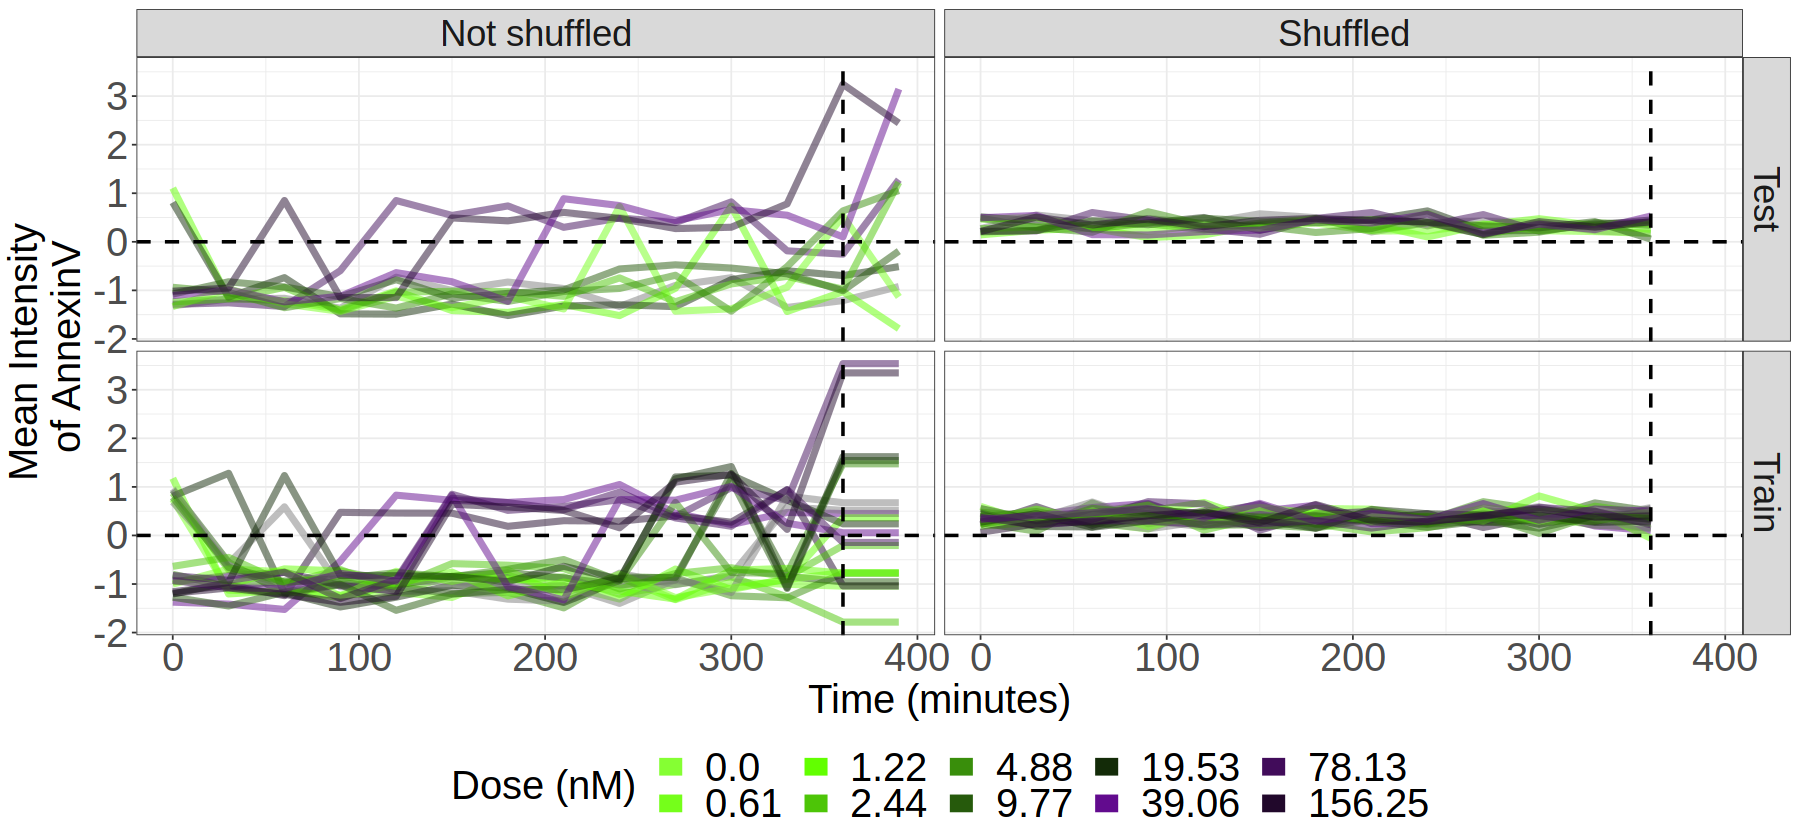

In [14]:
# plot the pca
feature_plot <- (
    ggplot(merged_results, aes(x = Metadata_Time, y = Terminal_Intensity_TotalIntensity_AnnexinV, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_grid(Metadata_data_split ~ shuffled)

    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)
    + geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 1)

    + labs(x="Time (minutes)", y="Mean Intensity \nof AnnexinV", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_pallete_for_dose)
    + guides(color = guide_legend( override.aes = list(size = 5, alpha = 1)))


)
ggsave(
    filename = "../figures/predicted_Terminal_Intensity_MaxIntensity_AnnexinV.png",
    plot = feature_plot,
    width = width,
    height = height,
    dpi = 600
)
feature_plot

### Patchwork for a final figure

In [15]:
feature_plot <- feature_plot + theme(legend.position = "none")
pca1_plot <- pca1_plot + theme(legend.position = "none")

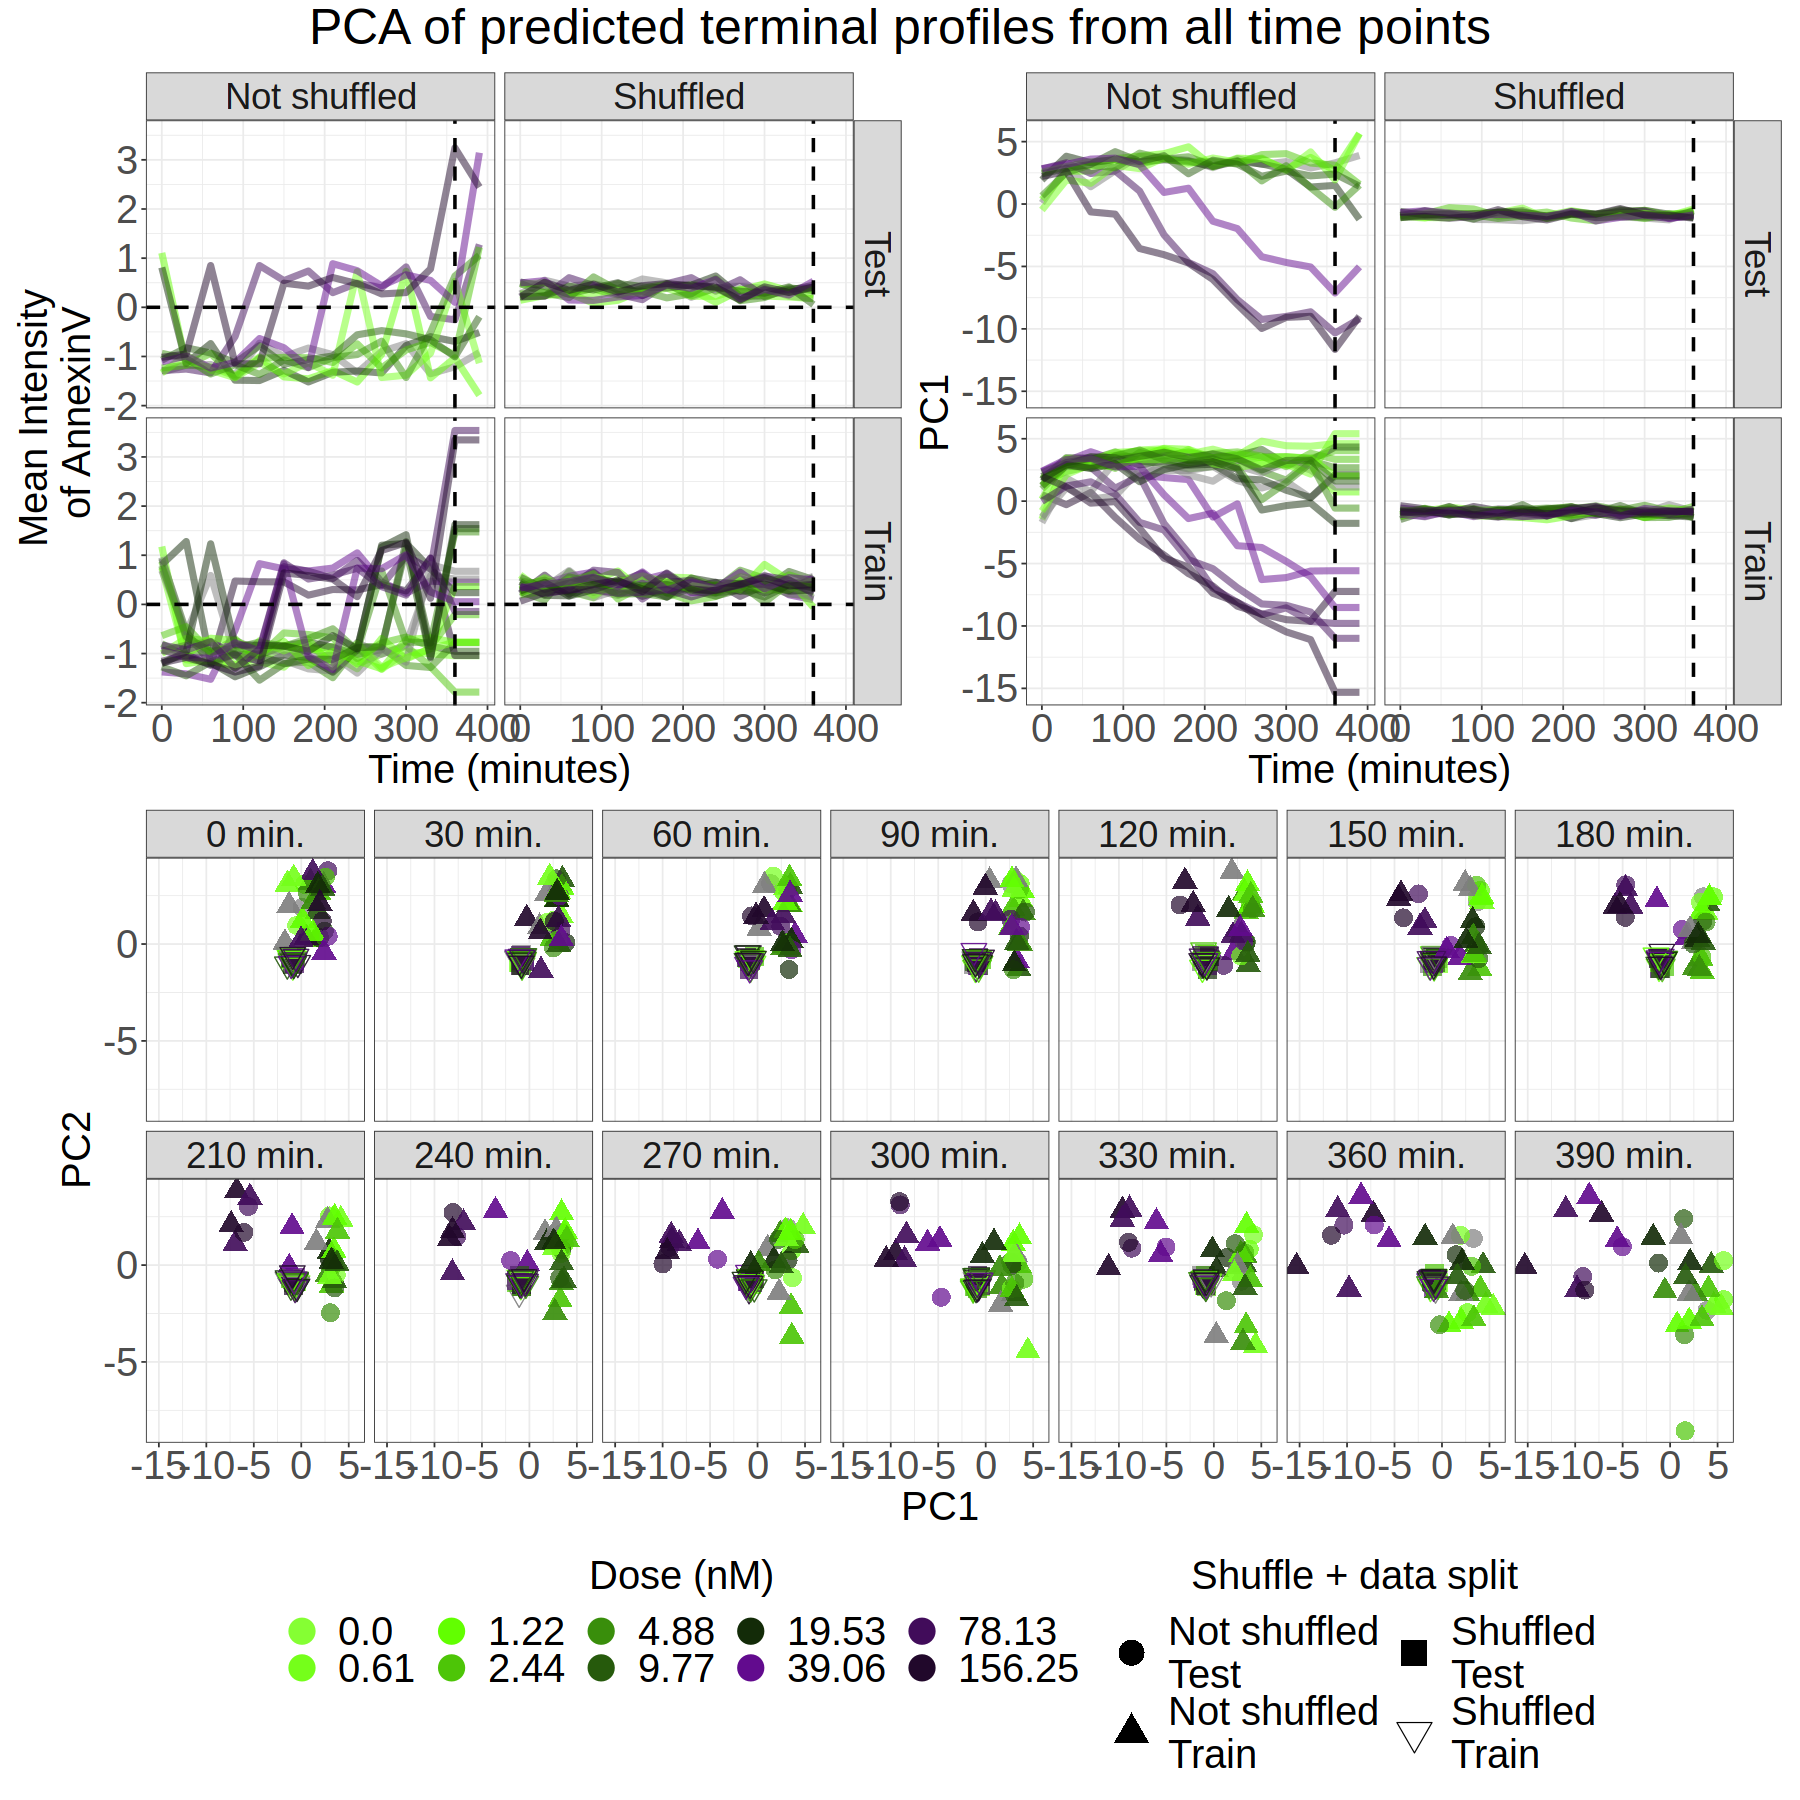

In [16]:
layout <- "
AABB
CCCC
"
height <- 15
width <- 15
options(repr.plot.width=width, repr.plot.height=height)
final_plot <- (
    feature_plot 
    + pca1_plot 
    + pca_over_time_plot
    + plot_layout(design = layout)
    + plot_annotation(
        title = "PCA of predicted terminal profiles from all time points",
        theme = theme(plot.title = element_text(size = 30, hjust = 0.5))
    )
)
ggsave(
    filename = "../figures/final_predicted_terminal_profiles_from_all_time_points.png",
    plot = final_plot,
    width = width,
    height = height,
    dpi = 600
)
final_plot